<h2>1. Contexte<h2/>

<h2>This notebook is dedicated to understanding the subject and exploring the data.<h2/>

<h3>"The dataset includes 174 metrics and 297,099 rows of data of tropical storms in the United States
collected from 1980 onwards. The data is raw, imperfect, and has not been cleaned or preprocessed."<h3/>

<h3>"Information about the dataset attributes can be found in the IBTRACS_variable_documentation file. Using the provided dataset, you are asked to train a model to predict the severity of a tropical cyclone based on geographical input data."<h3/>

We want to predict the 145th column of the dataset

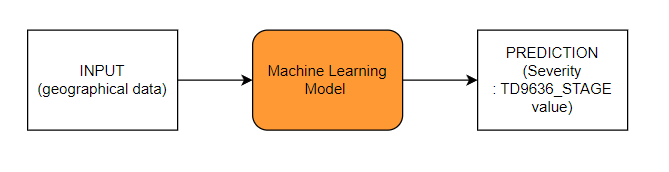

<h2>2. Data Exploration<h2/>

In [36]:
#Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import plotly.express as px
import seaborn as sns

We noticed that the first row, that gives units of certain columns needed to be removed, as it would have been an issuein our dataset. 

In [37]:
#Import and read the csv file, forcing the NaN values in case of formating issues. Display the 5 first rows

df = pd.read_csv("ibtracs.csv",low_memory=False, na_values=["", " ", "-", "NA", "N/A"],dtype=str,skiprows=[1]) # to correct the formating issue when importing the csv
df.head(5)

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,350
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,350
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,360
3,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,10
4,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 12:00:00,TS,-11.5,172.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,20


In [38]:
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])  # Convert to int ou float if possible
    except ValueError:
        pass  # Ignore errors

print(df.dtypes)

SID               object
SEASON             int64
NUMBER             int64
BASIN             object
SUBBASIN          object
                  ...   
USA_SEARAD_SE    float64
USA_SEARAD_SW    float64
USA_SEARAD_NW    float64
STORM_SPEED      float64
STORM_DIR        float64
Length: 174, dtype: object


In [39]:
# We highlight the columns that will be challenging, here the ones with NaN
df.isna().sum()

SID                   0
SEASON                0
NUMBER                0
BASIN             40518
SUBBASIN          32646
                  ...  
USA_SEARAD_SE    282038
USA_SEARAD_SW    283730
USA_SEARAD_NW    282124
STORM_SPEED           8
STORM_DIR             8
Length: 174, dtype: int64

In [40]:
# We count the number of NaN per columns to estimate the percentage of the df it represents
missing_values=df.isna().sum()
columns_with_missing = missing_values[missing_values >= 0]

# disable the display limit
pd.set_option("display.max_rows", None)

total_rows = len(df)
missing_percentage = (columns_with_missing / total_rows) * 100

print(missing_percentage.sort_values(ascending=False).to_frame(name="Missing Values Percentage"))

# reinitialize the configuration
pd.reset_option("display.max_rows")

                  Missing Values Percentage
MLC_LAT                          100.000000
TD9635_ROCI                      100.000000
REUNION_GUST                     100.000000
MLC_CLASS                        100.000000
MLC_WIND                         100.000000
MLC_PRES                         100.000000
TD9636_PRES                      100.000000
TD9635_LAT                       100.000000
TD9635_LON                       100.000000
TD9635_WIND                      100.000000
REUNION_R64_NW                   100.000000
REUNION_R64_NE                   100.000000
REUNION_R64_SW                   100.000000
REUNION_R64_SE                   100.000000
MLC_LON                          100.000000
TD9635_PRES                      100.000000
BOM_R64_NW                        99.806125
BOM_R64_SW                        99.800403
BOM_R64_SE                        99.795354
BOM_R64_NE                        99.792324
USA_RECORD                        99.754963
DS824_PRES                      

In [41]:
# Création d'un DataFrame pour Plotly
missing_df = pd.DataFrame({
    "Column Index": range(len(columns_with_missing)),
    "Column": columns_with_missing.index,  
    "Missing Percentage": missing_percentage.values  
})

# bar chart with plotly
fig = px.bar(
    missing_df,
    x="Column Index",
    y="Missing Percentage",
    text="Column",  #info-bulle
    title="Percentage of missing values per column"
)
fig.show()

#### Now, we have a first look at the columns and especially a more detailed vue of the ones with the most of missing values and the one without missing values. As we see by that and by looking directly at the csv file,a lot of columns have a high percentage of missing values:  **151/174 columns have more than 50% of missing values, and 16/174 columns have no values at all**

#### **We first decide to delete the columns that don't contain values, since they don't add anything.**

In [42]:
empty_columns=missing_percentage[missing_percentage==100]
df.drop(columns=empty_columns.index,inplace=True)
df.shape

(297098, 158)

#### Another important point to notice is that the target metric itself, `TD9636_STAGE` has **83,7% of missing values**, so we need to further our investigation.
### And it means that there are **48343 rows** with available value of TD9636_STAGE, which is still a considerate amount of data.

In [43]:
df["TD9636_STAGE"].value_counts()

TD9636_STAGE
2.0    17204
1.0    16028
4.0    10623
0.0     3156
3.0      742
5.0      331
6.0      259
Name: count, dtype: int64

In [44]:
df.loc[df.TD9636_STAGE.notna(),:]

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST,BOM_GUST_PER,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,350.0
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,350.0
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,360.0
3,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,10.0
4,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 12:00:00,TS,-11.5,172.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67405,1989354N05155,1989,129,WP,MM,JACK,1989-12-29 00:00:00,TS,14.6,141.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,250.0
67406,1989354N05155,1989,129,WP,MM,JACK,1989-12-29 03:00:00,TS,14.4,141.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,250.0
67407,1989354N05155,1989,129,WP,MM,JACK,1989-12-29 06:00:00,TS,14.3,140.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,250.0
67408,1989354N05155,1989,129,WP,MM,JACK,1989-12-29 09:00:00,TS,14.1,140.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,250.0


### **Handling of `TD9636_STAGE`**
83.7% of missing value is too important, we can't fill those.
#### **We keep only the rows where `TD9636_STAGE` is not missing**  
#### 📌 Advantages:  
- Ensures the model is trained only with complete data.  
- No need to handle missing target values.  
- Easier.  


In [45]:
df = df.dropna(subset=['TD9636_STAGE'])
df.shape

(48343, 158)

Now we can continue cleaning our data, because we still have a lot of columns with missing values that we can considere unusable.
By looking through the list og missing percentage, we notice that we have a significant gap of percentages under 43% of missing value.
So we chose to fix a threshold around 40%. If a column has more than 40% of missing values, we chose to remove it.

In [46]:
threshold=40
#we recalculate the percentages
missing_values=df.isna().sum()
columns_with_missing = missing_values[missing_values >= 0]
total_rows = len(df)
missing_percentage = (columns_with_missing / total_rows) * 100

#we remove columns with too many missing values
cols_to_drop=[col for col in df.columns if missing_percentage[col] > threshold]
df= df.drop(columns=cols_to_drop)
df.shape

(48343, 25)

In [47]:
df.columns

Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON', 'TRACK_TYPE', 'DIST2LAND', 'LANDFALL', 'IFLAG',
       'USA_ATCF_ID', 'USA_LAT', 'USA_LON', 'USA_WIND', 'USA_SSHS',
       'TD9636_LAT', 'TD9636_LON', 'TD9636_STAGE', 'TD9636_WIND',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object')

Among the remaining columns, we examined their relevance through their description in the ibtracs documentation. 
Hence,we decided to remove these columns that have useless information:
`SID`, `NAME`, `IFLAG`,`TRACK_TYPE`, `NUMBER`

In [48]:
df= df.drop(columns=["SID","NAME","NUMBER","IFLAG","TRACK_TYPE"])
df.shape

(48343, 20)

Moreover with the Ibtracs technical details we have information on some categories that are in fact equivalent to missing values. So we transform those to make it clear that it stands for NaN.

In [49]:
df["BASIN"] = df["BASIN"].replace("MM", np.nan)
df["SUBBASIN"] = df["SUBBASIN"].replace("MM", np.nan)
df["NATURE"] = df["NATURE"].replace("NR", np.nan)
df["USA_SSHS"] = df["USA_SSHS"].replace("-5", np.nan)

In [50]:
#we recalculate the percentages
missing_values=df.isna().sum()
columns_with_missing = missing_values[missing_values >= 0]
total_rows = len(df)
missing_percentage = (columns_with_missing / total_rows) * 100

print(missing_percentage.sort_values(ascending=False).to_frame(name="Missing Values Percentage"))


              Missing Values Percentage
SUBBASIN                      79.850237
TD9636_WIND                   17.886767
USA_WIND                      16.291914
USA_LAT                       14.651552
USA_LON                       14.651552
USA_ATCF_ID                   13.760007
TD9636_LAT                     2.155431
TD9636_LON                     2.155431
LANDFALL                       0.930848
NATURE                         0.268912
STORM_SPEED                    0.002069
STORM_DIR                      0.002069
ISO_TIME                       0.000000
BASIN                          0.000000
SEASON                         0.000000
DIST2LAND                      0.000000
LON                            0.000000
LAT                            0.000000
USA_SSHS                       0.000000
TD9636_STAGE                   0.000000


In [51]:
# Now we see that "SUBBASIN" has in fact many missing values, we remove this feature
df = df.drop(columns=["SUBBASIN"])
df.shape

(48343, 19)

We look for any columns with a null variance, that is to say, with one unique value.If this is the case, we canremove it since it doesn't add information

In [52]:
unique_counts = df.nunique()
unique_counts

SEASON             10
BASIN               5
ISO_TIME        24417
NATURE              4
LAT               862
LON              2605
DIST2LAND        3034
LANDFALL         3012
USA_ATCF_ID       772
USA_LAT           804
USA_LON          2356
USA_WIND          112
USA_SSHS           10
TD9636_LAT        836
TD9636_LON       2374
TD9636_STAGE        7
TD9636_WIND       140
STORM_SPEED        66
STORM_DIR          73
dtype: int64

Now we are going to look for correlations(between features, and with the target) to continue our data cleaning.

In [53]:
# to work on correlations, we start by identifying categorical columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()
cat_cols

['BASIN', 'ISO_TIME', 'NATURE', 'USA_ATCF_ID']

In [54]:
num_cols

['SEASON',
 'LAT',
 'LON',
 'DIST2LAND',
 'LANDFALL',
 'USA_LAT',
 'USA_LON',
 'USA_WIND',
 'USA_SSHS',
 'TD9636_LAT',
 'TD9636_LON',
 'TD9636_STAGE',
 'TD9636_WIND',
 'STORM_SPEED',
 'STORM_DIR']

In [55]:
#we create a dataframe with the metrics we want to study
missing_values=df.isna().sum()
columns_with_missing = missing_values[missing_values > 0]
df_NaN=df[columns_with_missing.index]
df_NaN.head(2)

,NATURE,LANDFALL,USA_ATCF_ID,USA_LAT,USA_LON,USA_WIND,TD9636_LAT,TD9636_LON,TD9636_WIND,STORM_SPEED,STORM_DIR
0,TS,647.0,SH051980,-12.5,172.5,25.0,-12.5,172.5,25.0,6.0,350.0
1,TS,653.0,SH051980,-12.2,172.4,25.0,-12.2,172.5,NaN,6.0,350.0


In [56]:
columns_with_missing

NATURE          130
LANDFALL        450
USA_ATCF_ID    6652
USA_LAT        7083
USA_LON        7083
USA_WIND       7876
TD9636_LAT     1042
TD9636_LON     1042
TD9636_WIND    8647
STORM_SPEED       1
STORM_DIR         1
dtype: int64

In [57]:
df_le=df_NaN.copy()

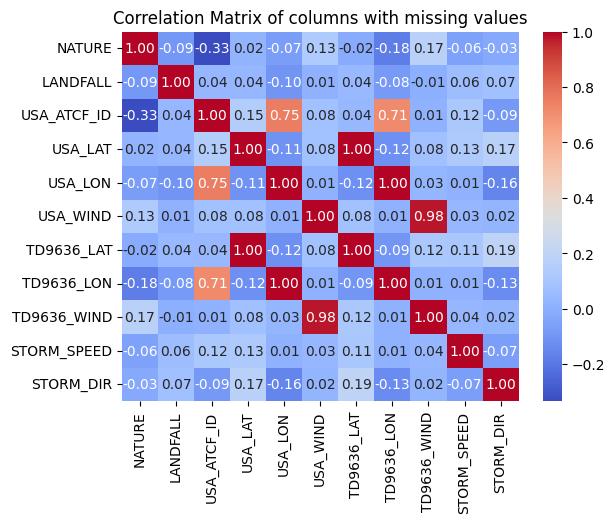

In [64]:
from sklearn.preprocessing import LabelEncoder

#we want to encode "NATURE" and "USA_ATCF_ID", that have missing values and are categorical
for col in ["NATURE","USA_ATCF_ID"]:
    le = LabelEncoder()
    df_le[col] = le.fit_transform(df_le[col])
correlation_matrix = df_le.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of columns with missing values")
plt.show()

When two features are too correlated, we keep only one, refering the documentation to keep the more relevant.

In [65]:
df_le= df_le.drop(columns=["TD9636_WIND", "USA_LON","USA_LAT"])
df_le.shape

(48343, 8)

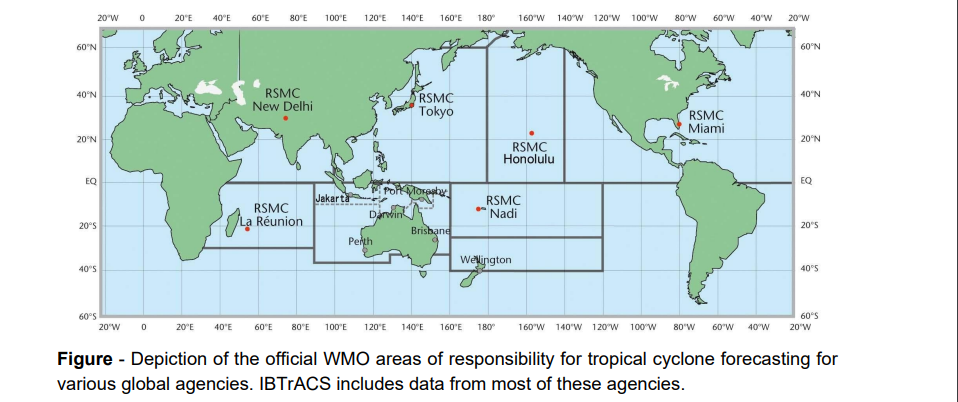